In [1]:
import torch
from control_stork.optimizers import SMORMS3
from control_stork.nodes import LIFGroup, FastLIFGroup, NoisyFastLIFGroup
from control_stork.nodes import (
    InputGroup,
    ReadoutGroup,
    FastReadoutGroup,
    DirectReadoutGroup,
    TimeAverageReadoutGroup,
)
from control_stork.connections import Connection, BottleneckLinearConnection
from control_stork.models import RecurrentSpikingModel
from control_stork.initializers import (
    FluctuationDrivenCenteredNormalInitializer,
    KaimingNormalInitializer,
    DistInitializer,
    AverageInitializer,
)
from control_stork.monitors import (
    MeanVarianceMonitor,
    SpikeMonitor,
    SpikeCountMonitor,
    StateMonitor,
    PopulationFiringRateMonitor,
    PopulationSpikeCountMonitor,
    PlotStateMonitor,
)
from control_stork.regularizers import LowerBoundL2, UpperBoundL2
from control_stork.activations import SigmoidSpike
from control_stork.layers import Layer
from control_stork.plotting import plot_traces, plot_spikes
from control_stork.extratypes import *

import time
import math
import matplotlib
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device", device)

# torch.autograd.set_detect_anomaly(True)

using device cpu


In [3]:
# model size
n_hidden = 2
input_dim = 2
hidden_dim = 256
output_dim = input_dim
feedback = False

# neuron parameters
neuron_class = FastLIFGroup  # NoisyFastLIFGroup  # FastLIFGroup
neuron_kwargs = dict(
    tau_mem=5e-3,  # BEST WAS 10e-3
    tau_syn=2e-3,  # BEST WAS 5e-3
    activation=SigmoidSpike,
)  #'noise_std': 0.05}
connection_class = BottleneckLinearConnection  # Connection
recurrent = True
connection_kwargs = dict(
    bias=True,
    n_dims=10,
)

# readout parameters
readout_class = FastReadoutGroup
readout_kwargs = dict(
    n_readouts=100,
    tau_mem_out=0.005,
    tau_syn_out=0.002,
)

# initialize weights
sigma_u = 1.0
nu = 15  # ! Check this parameter again
time_step = 2e-3

# optimizer parameters
lr = 5e-4
optimizer_class = SMORMS3  # torch.optim.Adam # SMORMS3

# regularization parameters
lowerBoundL2Strength = 0.0
lowerBoundL2Threshold = 1e-3
upperBoundL2Strength = 0.0  # 0.1
upperBoundL2Threshold = (
    4  # Regularizes spikecount: 4 spikes ~ 20 Hz in 200ms simulation time
)


# make the model
rsm = RecurrentSpikingModel(
    device=device,
)

# make the initializers
initializer = FluctuationDrivenCenteredNormalInitializer(
    sigma_u=sigma_u,
    nu=nu,
    time_step=time_step,
)

# make the regularizers
regs = []
if lowerBoundL2Strength > 0:
    regLB = LowerBoundL2(
        lowerBoundL2Strength, threshold=lowerBoundL2Threshold, dims=False
    )
    regs.append(regLB)
if upperBoundL2Strength > 0:
    regUB = UpperBoundL2(upperBoundL2Strength, threshold=upperBoundL2Threshold, dims=1)
    regs.append(regUB)
neuron_kwargs["store_sequences"] = ["out"] if regs else []

# make the groups and connections
input_group = prev = rsm.add_group(InputGroup(input_dim, name="Input Group"))
for i in range(n_hidden):
    new = Layer(
        name=f"Hidden Cell Group {i+1}",
        model=rsm,
        size=hidden_dim,
        input_group=prev,
        recurrent=recurrent,
        regs=regs,
        connection_class=connection_class,
        neuron_class=neuron_class,
        neuron_kwargs=neuron_kwargs,
        connection_kwargs=connection_kwargs,
    )
    initializer.initialize(new)
    prev = new.output_group

output_layer = new = Layer(
    name="Readout Pool Layer",
    model=rsm,
    size=output_dim * readout_kwargs["n_readouts"],
    input_group=prev,
    recurrent=False,
    regs=regs,
    connection_class=connection_class,
    neuron_class=readout_class,
    neuron_kwargs=neuron_kwargs,
    connection_kwargs=connection_kwargs,
)
initializer.initialize(new)
prev = new.output_group

readout_initializer = AverageInitializer()
output_group = new = rsm.add_group(
    TimeAverageReadoutGroup(output_dim, steps=5, name="Average Readout Group")
)
con = rsm.add_connection(Connection(prev, new, bias=False, requires_grad=False))
con.init_parameters(readout_initializer)

if feedback:
    feedback_con = rsm.add_connection(Connection(new, rsm.groups[1], bias=False))
    feedback_con.init_parameters(initializer=initializer)

# make the monitors
for i in range(n_hidden):
    # rsm.add_monitor(PopulationSpikeCountMonitor(rsm.groups[1+i], per_example=True))
    rsm.add_monitor(PopulationSpikeCountMonitor(rsm.groups[1 + i], avg=True))
    rsm.add_monitor(
        PlotStateMonitor(
            rsm.groups[1 + i],
            "out",
            plot_fn=plot_spikes,
            title=f"Hidden Cell Group {i+1}",
        )
    )
    rsm.add_monitor(
        PlotStateMonitor(
            rsm.groups[1 + i],
            "mem",
            plot_fn=plot_traces,
            title=f"Hidden Cell Group {i+1}",
        )
    )
    rsm.add_monitor(MeanVarianceMonitor(rsm.groups[1 + i], "out", dim=(0, 1)))
rsm.add_monitor(
    PlotStateMonitor(
        rsm.groups[-2], "out", plot_fn=plot_traces, title="Readout Pool Layer"
    )
)
rsm.add_monitor(
    PlotStateMonitor(
        rsm.groups[-1], "out", plot_fn=plot_traces, title="Average Readout Group"
    )
)
rsm.add_monitor(MeanVarianceMonitor(rsm.groups[-2], "out", dim=(0, 1)))
rsm.add_monitor(MeanVarianceMonitor(rsm.groups[-1], "out", dim=(0, 1)))


rsm.configure(
    input_group,
    output_group,
    optimizer=optimizer_class,
    optimizer_kwargs={"lr": lr},
    time_step=time_step,
)

rsm.summary()


# Model summary

## Groups
Input Group, (2,)
Hidden Cell Group 1, (256,)
Hidden Cell Group 2, (256,)
Readout Pool Layer, (200,)
Average Readout Group, (2,)

## Connections
BottleneckLinearConnection(
  (src): InputGroup() Input Group
  (dst): FastLIFGroup() Hidden Cell Group 1
  (pre_op): Linear(in_features=2, out_features=10, bias=True)
  (op): Linear(in_features=10, out_features=256, bias=True)
) 
BottleneckLinearConnection(
  (src): FastLIFGroup() Hidden Cell Group 1
  (dst): FastLIFGroup() Hidden Cell Group 1
  (pre_op): Linear(in_features=256, out_features=10, bias=True)
  (op): Linear(in_features=10, out_features=256, bias=True)
) 
BottleneckLinearConnection(
  (src): FastLIFGroup() Hidden Cell Group 1
  (dst): FastLIFGroup() Hidden Cell Group 2
  (pre_op): Linear(in_features=256, out_features=10, bias=True)
  (op): Linear(in_features=10, out_features=256, bias=True)
) 
BottleneckLinearConnection(
  (src): FastLIFGroup() Hidden Cell Group 2
  (dst): FastLIFGroup() Hidden Cell Gr

In [4]:
# data parameters
T_warmup = 20
T_data = 80
T = T_warmup + T_data
sec = T * time_step
print(f"Data to process is equivalent to {sec} seconds with dt = {time_step} seconds")
N = 101

data = (torch.rand(N, 1, input_dim) - 0.5) * 2
data = data.repeat(1, T, 1)
data = data.to(device)
target = data.clone()[:, :-T_warmup]

# test the model
with torch.no_grad():
    start = time.time()
    rsm.reset_state(N)
    y = rsm(data, record=True)
    end = time.time()
    print(f"Forward pass took {end-start:.4f} seconds")
    task_loss = torch.mean((y[:, T_warmup:] - target) ** 2)
    reg_loss = rsm.compute_regularizer_losses()
    total_loss = task_loss + reg_loss

print(
    f"Task Loss: {task_loss.item():.4f} - Reg Loss: {reg_loss.item():.4f} - Total Loss: {total_loss.item():.4f}"
)

Data to process is equivalent to 0.2 seconds with dt = 0.002 seconds
Forward pass took 0.0605 seconds
Task Loss: 0.3179 - Reg Loss: 0.0000 - Total Loss: 0.3179


PopulationSpikeCountMonitor on Hidden Cell Group 1
0.4009286165237427
firing rate: 200.46430826187134
spike density: 0.4009286165237427
PlotStateMonitor on Hidden Cell Group 1 for out
PlotStateMonitor on Hidden Cell Group 1 for mem
MeanVarianceMonitor on Hidden Cell Group 1 for out
tensor([0.4009, 0.0018])
PopulationSpikeCountMonitor on Hidden Cell Group 2
0.2845192551612854
firing rate: 142.2596275806427
spike density: 0.2845192551612854
PlotStateMonitor on Hidden Cell Group 2 for out
PlotStateMonitor on Hidden Cell Group 2 for mem
MeanVarianceMonitor on Hidden Cell Group 2 for out
tensor([0.2845, 0.0020])
PlotStateMonitor on Readout Pool Layer for out
PlotStateMonitor on Average Readout Group for out
MeanVarianceMonitor on Readout Pool Layer for out
tensor([0.5701, 0.0178])
MeanVarianceMonitor on Average Readout Group for out
tensor([0.0390, 0.0001])


/var/folders/kc/qjgbvcw93g91g3dh_00vk0bh0000gp/T/ipykernel_31412/2710667854.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  v.show()


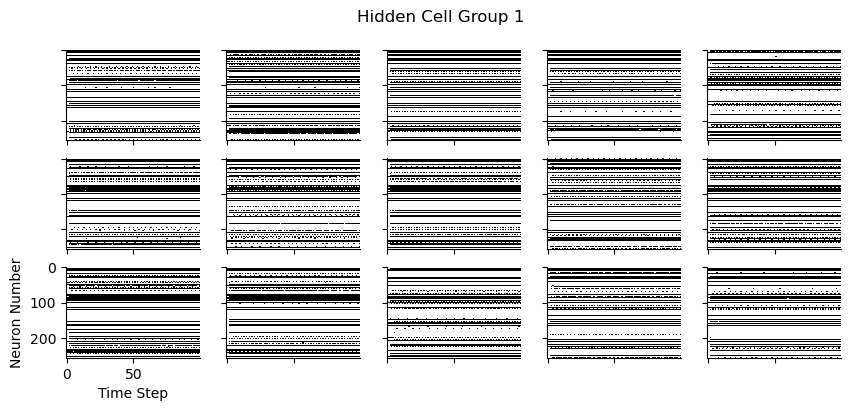

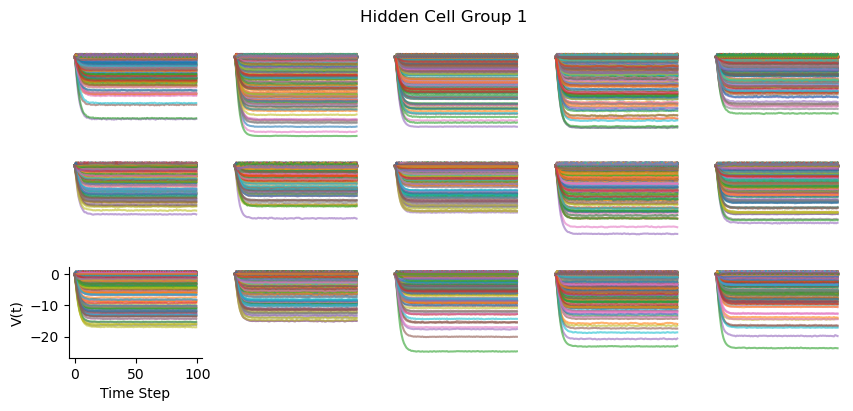

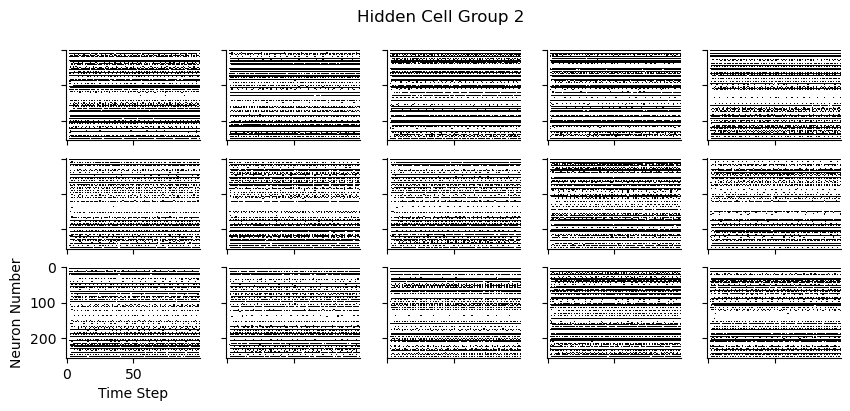

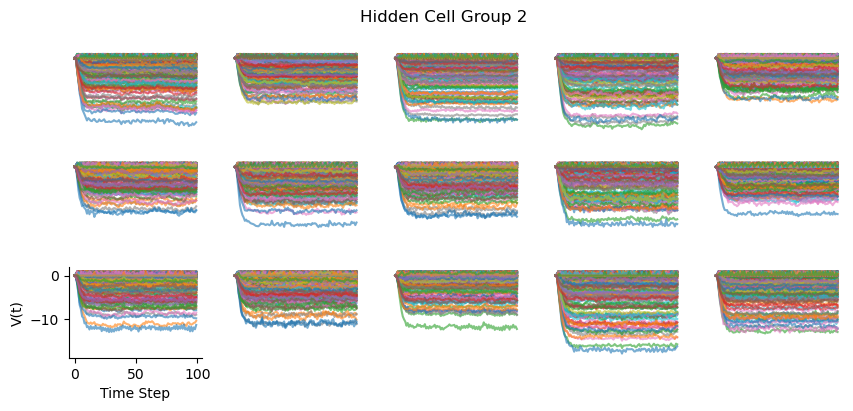

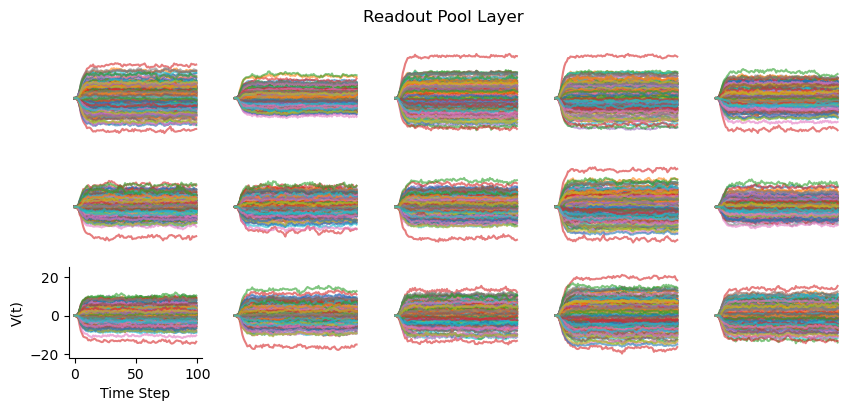

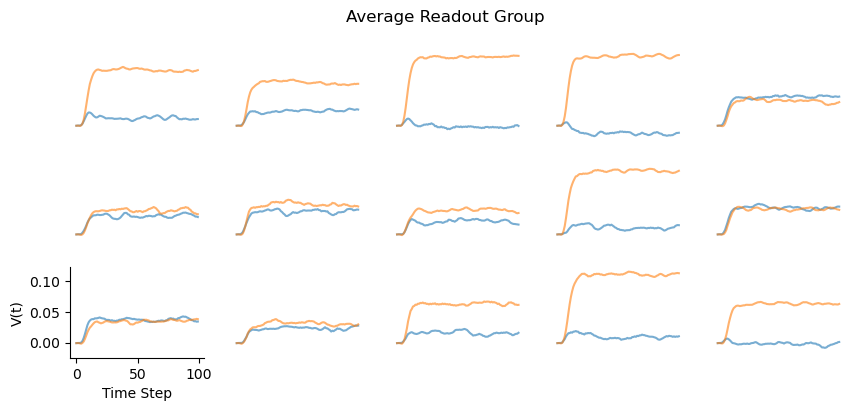

In [5]:
data = rsm.get_monitor_data()
for k, v in data.items():
    print(k)
    if isinstance(v, matplotlib.figure.Figure):
        v.show()
    elif v is None:
        print("None")
    elif "PopulationSpikeCountMonitor" in k:
        print("firing rate:", v.item() / (time_step))
        print("spike density:", v.item())
    else:
        print(v)

PopulationSpikeCountMonitor on Hidden Cell Group 1
torch.Size([])
PlotStateMonitor on Hidden Cell Group 1 for out


AttributeError: 'Figure' object has no attribute 'shape'

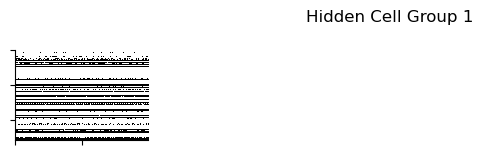

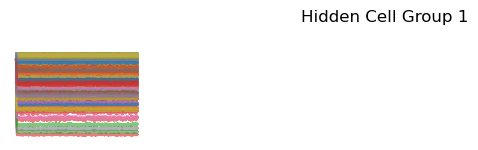

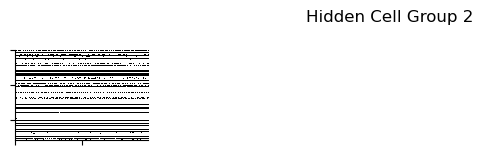

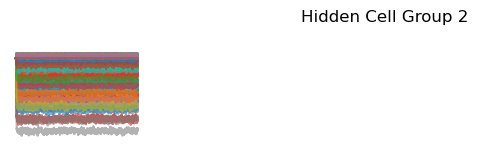

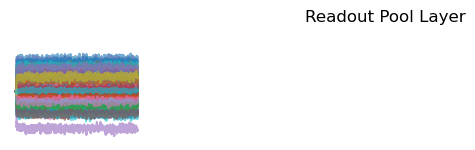

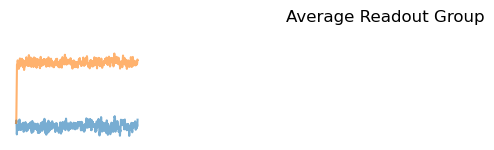

In [11]:
data = rsm.get_monitor_data()
for k, v in data.items():
    print(k)
    print(v.shape)
    if "StateMonitor" in k:
        if "Readout" in k:
            plot_traces(v, title=k, show=True)
        elif "Hidden" in k:
            if "mem" in k:
                plot_traces(v, title=k, show=True)
            elif "out" in k:
                plot_spikes(v, title=k, show=True)

tensor([0.0707, 0.0707])


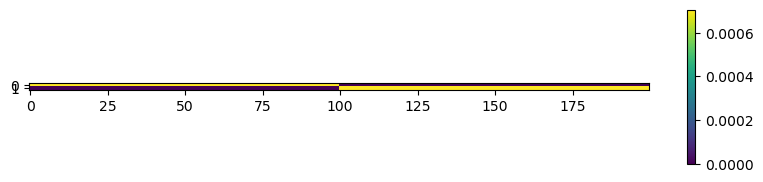

In [8]:
w = rsm.connections[-1].op.weight.detach().cpu()
print(w.sum(1))
fig = plt.figure(figsize=(10, 2))
plt.imshow(w)
plt.colorbar()
plt.show()

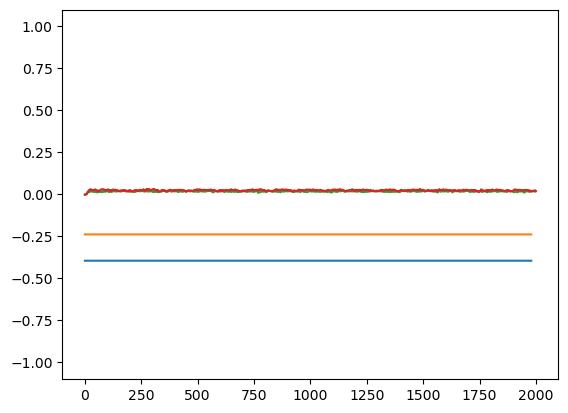

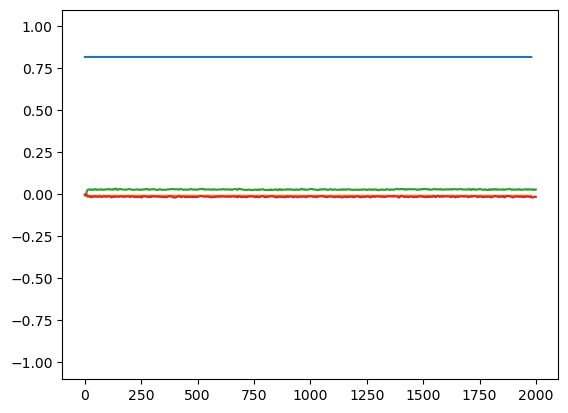

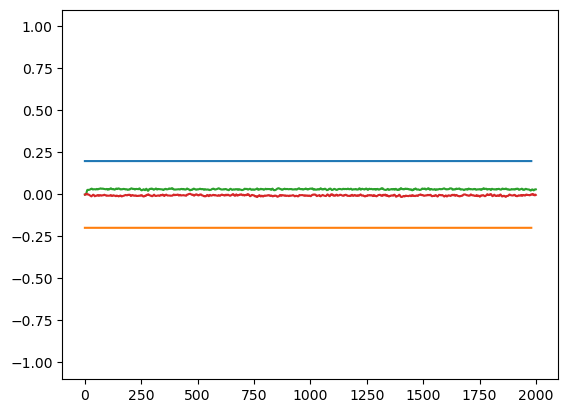

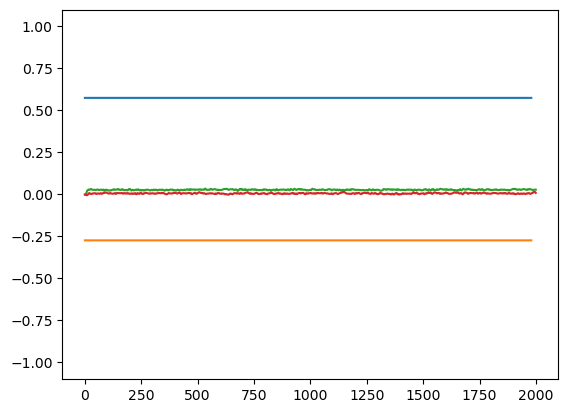

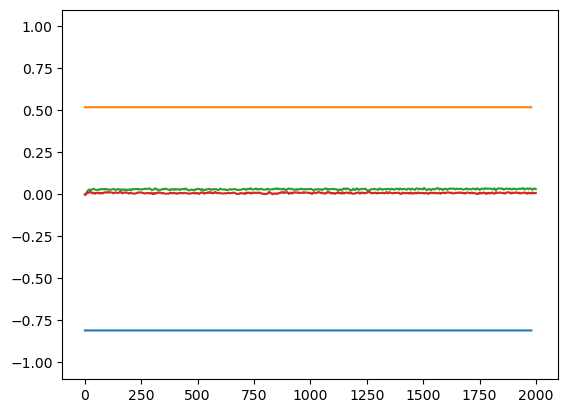

In [9]:
for i in range(5):
    plt.plot(target[i].cpu())
    plt.plot(y[i].detach().cpu())
    plt.ylim(-1.1, 1.1)
    plt.show()

Epoch 1/1000 - Task Loss: 0.35339 - Reg Loss: 0.00000 - Total Loss: 0.35339
Epoch 101/1000 - Task Loss: 0.00371 - Reg Loss: 0.00000 - Total Loss: 0.00371
Epoch 201/1000 - Task Loss: 0.00063 - Reg Loss: 0.00000 - Total Loss: 0.00063
Epoch 301/1000 - Task Loss: 0.00031 - Reg Loss: 0.00000 - Total Loss: 0.00031
Epoch 401/1000 - Task Loss: 0.00032 - Reg Loss: 0.00000 - Total Loss: 0.00032
Epoch 501/1000 - Task Loss: 0.00017 - Reg Loss: 0.00000 - Total Loss: 0.00017
Epoch 601/1000 - Task Loss: 0.00016 - Reg Loss: 0.00000 - Total Loss: 0.00016
Epoch 701/1000 - Task Loss: 0.00014 - Reg Loss: 0.00000 - Total Loss: 0.00014
Epoch 801/1000 - Task Loss: 0.00014 - Reg Loss: 0.00000 - Total Loss: 0.00014
Epoch 901/1000 - Task Loss: 0.00014 - Reg Loss: 0.00000 - Total Loss: 0.00014
Epoch 1000/1000 - Task Loss: 0.00012 - Reg Loss: 0.00000 - Total Loss: 0.00012


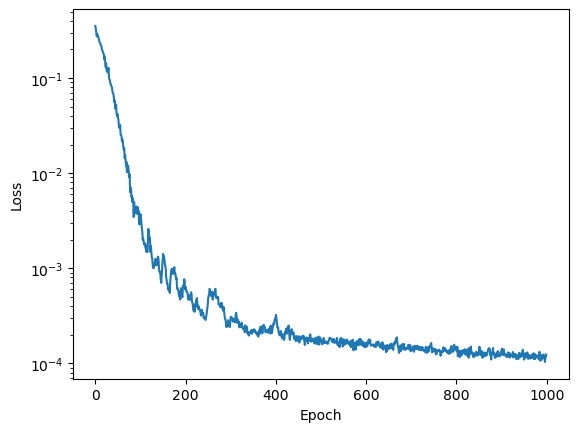

In [10]:
# data parameters
T_warmup = 20
T_data = 80
T = T_warmup + T_data
sec = T * time_step
N = 256

# training parameters
epochs = 1000

losses = []

for e in range(epochs):
    data = (torch.rand(N, 1, input_dim) - 0.5) * 2
    data = data.repeat(1, T, 1)
    data = data.to(device)
    target = data.clone()[:, :-T_warmup]

    rsm.reset_state(N)
    y = rsm(data, record=True)
    task_loss = torch.mean((y[:, T_warmup:] - target) ** 2)
    reg_loss = rsm.compute_regularizer_losses()
    total_loss = task_loss + reg_loss
    rsm.optimizer_instance.zero_grad()
    total_loss.backward()
    rsm.optimizer_instance.step()

    losses.append([total_loss.item()])
    if e % 100 == 0 or e == epochs - 1:
        print(
            f"Epoch {e+1}/{epochs} - Task Loss: {task_loss.item():.5f} - Reg Loss: {reg_loss.item():.5f} - Total Loss: {total_loss.item():.5f}"
        )

plt.plot(losses)
plt.yscale("log")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

tensor([-0.9738,  0.8217])
tensor([-0.9775,  0.8170])


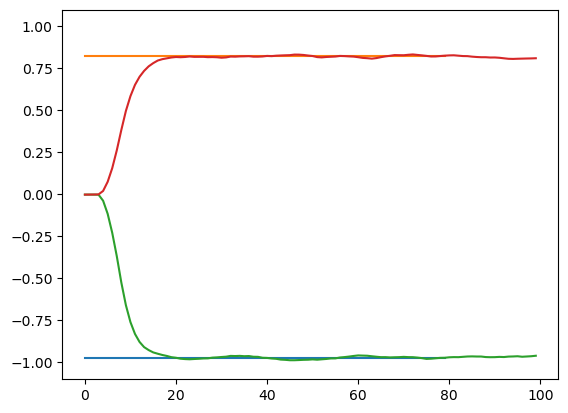

tensor([-0.8533,  0.0587])
tensor([-0.8515,  0.0650])


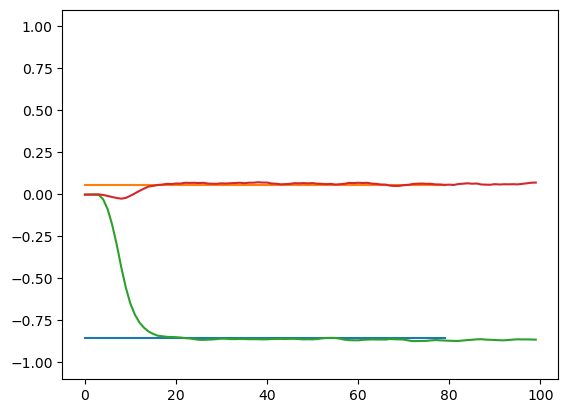

tensor([-0.3865, -0.7114])
tensor([-0.3789, -0.7073])


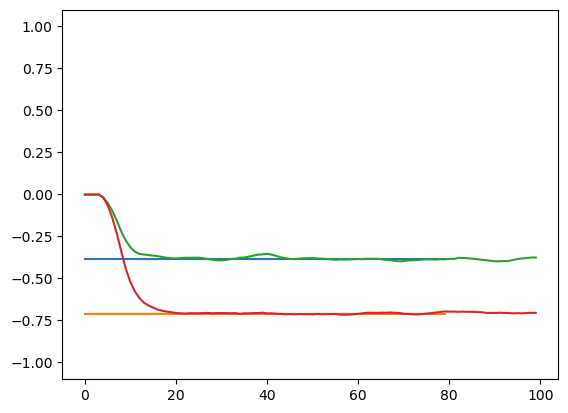

tensor([ 0.2738, -0.2331])
tensor([ 0.2877, -0.2289])


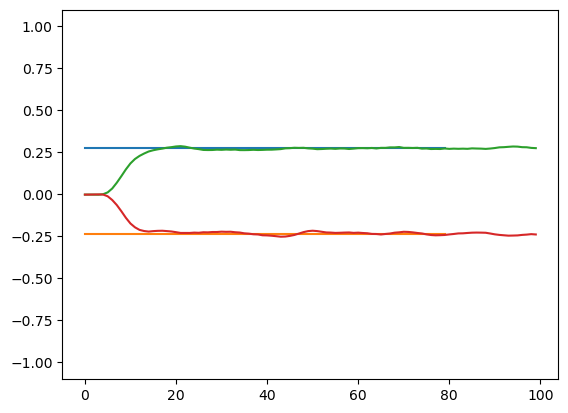

tensor([ 0.6788, -0.4991])
tensor([ 0.6636, -0.4840])


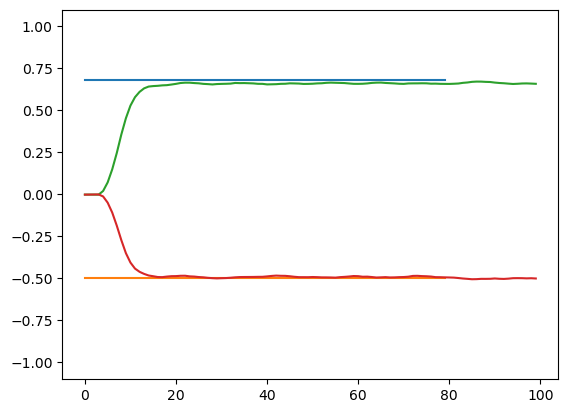

tensor([-0.6142, -0.9391])
tensor([-0.6187, -0.9378])


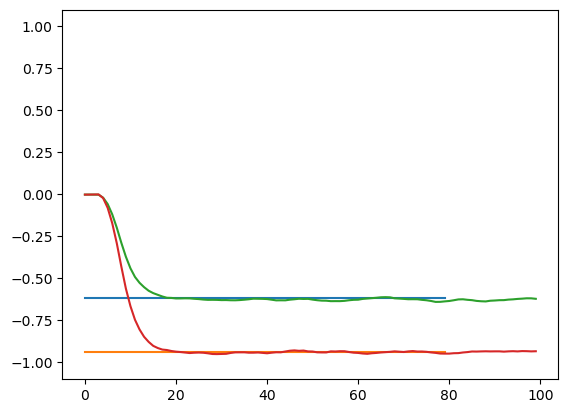

tensor([-0.1513, -0.3656])
tensor([-0.1478, -0.3807])


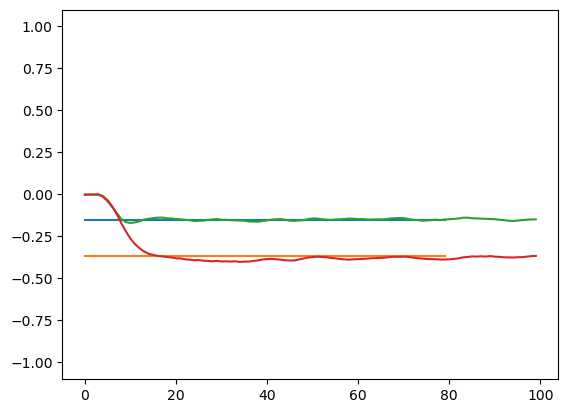

tensor([0.1578, 0.8430])
tensor([0.1590, 0.8445])


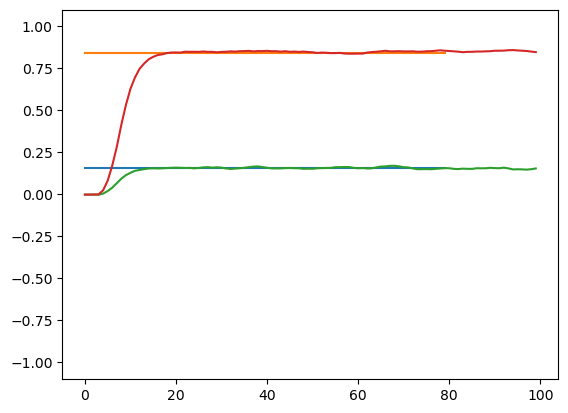

tensor([-0.4310,  0.6232])
tensor([-0.4282,  0.5900])


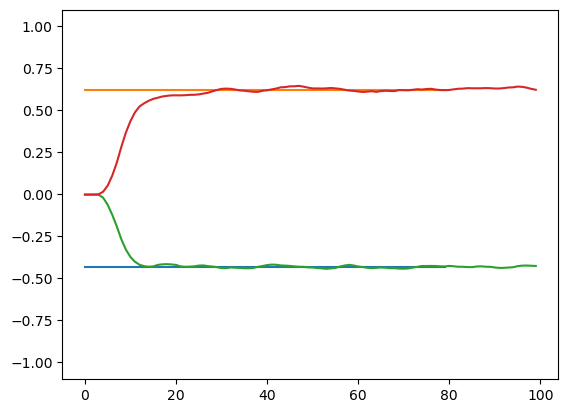

tensor([0.6148, 0.5565])
tensor([0.6080, 0.5562])


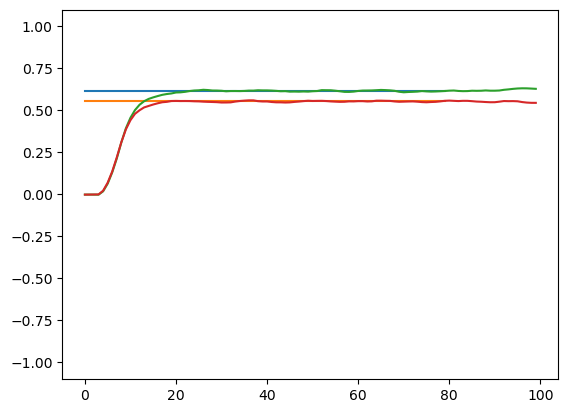

In [11]:
for i in range(10):
    print(target.cpu()[i][0])
    # print(y.detach().cpu()[i][T_warmup+10:T_warmup+15].mean(0))
    print(y.detach().cpu()[i][T_warmup + 1])
    plt.plot(target[i].cpu())
    plt.plot(y[i].detach().cpu())
    plt.ylim(-1.1, 1.1)
    plt.show()

tensor([0.0707, 0.0707])


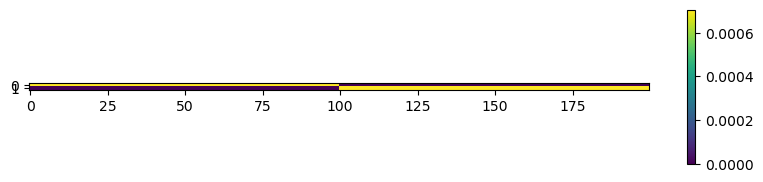

In [12]:
w = rsm.connections[-1].op.weight.detach().cpu()
print(w.sum(1))
fig = plt.figure(figsize=(10, 2))
plt.imshow(w)
plt.colorbar()
plt.show()

In [13]:
for i, m in enumerate(rsm.monitors):
    m_type = m.__class__.__name__
    m_group = m.group.name
    print(f"Monitor {i+1} of type {m_type} on {m_group}")
    print(m.get_data().shape)
    # print(m.get_data() / sec)
    # print(torch.mean(m.get_data()))
    # print(torch.count_nonzero(m.get_data()) / torch.numel(m.get_data()))
    # print(m.get_data())
    if m_type == "SpikeCountMonitor":
        print(f"Average spikes per second: {torch.mean(m.get_data() / sec).item():.3f}")
        # print(f'Number of active neurons:')
        # print(torch.count_nonzero(m.get_data(), dim=0))
        # for i in range(5):
        #    print(m.get_data()[i])
    if m_type == "StateMonitor":
        if "Hidden" in m_group:
            plot_spikes(m.get_data(), title=f"{m_group}")
        elif "Readout" in m_group:
            plot_traces(m.get_data(), title=f"{m_group}")

Monitor 1 of type SpikeCountMonitor on Hidden Cell Group 1
torch.Size([256, 256])
Average spikes per second: 182.011
Monitor 2 of type StateMonitor on Hidden Cell Group 1
torch.Size([256, 100, 256])
Monitor 3 of type SpikeCountMonitor on Hidden Cell Group 2
torch.Size([256, 256])
Average spikes per second: 193.529
Monitor 4 of type StateMonitor on Hidden Cell Group 2
torch.Size([256, 100, 256])
Monitor 5 of type StateMonitor on Readout Pool Layer
torch.Size([256, 100, 200])
Monitor 6 of type StateMonitor on Average Readout Group
torch.Size([256, 100, 2])
